In [2]:
# Import the famous library from Python 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt

import pandas as pd
import pickle
import warnings

import cv2
import os

# gráfico
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
# from albumentations.augmentations.blur import MotionBlur, Defocus
import albumentations as A
from albumentations.pytorch import ToTensorV2
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# %cd /kaggle/working
# %cd ../input/celeba-spoof-for-face-antispoofing
# !pwd

In [4]:
def get_ratio_bbox_and_image(full_img_path, bound_box_path):
    img = cv2.imread(full_img_path)
    real_h, real_w, _ = img.shape
    area_image = real_h * real_w
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
    area_bbox = w1*h1
    return area_bbox / area_image


def standard_width_height_scaling(real_w, real_h, bbox0, bbox1, bbox2, bbox3):
    x1 = int(int(bbox0)*(float(real_w) / 224)) # bbox[0]
    y1 = int(int(bbox1)*(float(real_h) / 224)) # bbox[1]
    w1 = int(int(bbox2)*(float(real_w) / 224)) # bbox[2]
    h1 = int(int(bbox3)*(float(real_h) / 224)) # bbox[3]
    return x1, y1, w1, h1


def get_area_bbox_indices(bound_box_path, real_w, real_h):
    bound_box_read = open(bound_box_path, "r")
    bound_box_indices = list()
    for i in bound_box_read:
        bound_box_indices.append(i)
    bbox = bound_box_indices[0].split()
    x1, y1, w1, h1 = standard_width_height_scaling(real_w, real_h, 
                                                   bbox[0], bbox[1], bbox[2], bbox[3])
    return x1, y1, w1, h1

def get_padding_bbox_indices(x1, y1, w1, h1, real_w, real_h, ratio_bbox_and_image):
    x1_padding = x1 - int((w1) * (1+ratio_bbox_and_image))
    y1_padding = y1 - int((h1) * (1+ratio_bbox_and_image))
    w1_padding = w1 + int((w1) * (1+ratio_bbox_and_image))
    h1_padding = h1 + int((h1) * (1+ratio_bbox_and_image))
    if x1_padding < 0: 
        x1_padding = 0
    if y1_padding < 0:
        y1_padding = 0
    if w1_padding > real_w:
        w1_padding = real_w
    if h1_padding > real_h:
        h1_padding = real_h
    return x1_padding, y1_padding, w1_padding, h1_padding
    
def read_crop_img_with_bbox(full_img_path, bound_box_path):
    img = cv2.imread(full_img_path)
#     print(f"bound_box_path: {bound_box_path}")
#     print(f'bound box: {bbox}')
    real_w = img.shape[1]
    real_h = img.shape[0]
#     print(f'read_w = {img.shape[1]}')
#     print(f'read_h = {img.shape[0]}')
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
#     print(f'x1={x1}, y1={y1}, w1={w1}, and h1={h1}')
    return x1, y1, w1, h1, img, real_w, real_h

In [5]:
# Live Storage
original_cropped_storage = []
padding_cropped_storage = []
img_names = []
original_cropped_labels = []
padding_cropped_labels = []

count_live = 0
count_spoof = 0
dim = (128, 128)
count_limit_live = 5000
count_limit_spoof = 5000

rootdir_train = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train'
for file in os.listdir(rootdir_train):
#     file = '1'
    # file is 1, 1000, ..... 10029,...... => Name of folder 
    d = os.path.join(rootdir_train, file)
    if os.path.isdir(d):
        for e in os.listdir(d):
            # e is "live" of "spoof"
            imgs_path = d + '/' + e + '/'
#             print(imgs)
            for img_path in os.listdir(imgs_path):
#                 print(img_path)
#                 imgs_path = '000184.jpg'
                if (img_path.endswith(".jpg")):
                    full_img_path = imgs_path + img_path
#                     print('full_img_path: {full_img_path}')
                    bound_box_path = full_img_path[0:-4] + '_BB.txt'
#                     print(f'bound_box_path: {bound_box_path}')
                    x1, y1, w1, h1, img, real_w, real_h = read_crop_img_with_bbox(full_img_path, bound_box_path)
                    ratio_bbox_and_image = get_ratio_bbox_and_image(full_img_path, bound_box_path)
#                     print(f'ratio_bbox_and_image = {ratio_bbox_and_image}')
                    x1_padding, y1_padding, w1_padding, h1_padding = get_padding_bbox_indices(x1, y1, w1, h1, 
                                                                                              real_w, real_h,
                                                                                              ratio_bbox_and_image)
#                     print(x1_padding, y1_padding, w1_padding, h1_padding)
#                     plt.imshow(img[y1_padding:y1+h1_padding,
#                                    x1_padding:x1+w1_padding])
                    padding_img = img[y1_padding:y1+h1_padding, x1_padding:x1+w1_padding]
                    try:
                        if (e == 'live' and count_live >= count_limit_live) or (e == 'spoof' and count_spoof >= count_limit_spoof):
                            continue
                        resized_padding_img = cv2.resize(padding_img, dim, interpolation = cv2.INTER_AREA)
                        padding_cropped_storage.append(resized_padding_img)
                        if e == 'live':
                            count_live = count_live + 1
                            padding_cropped_labels.append(1)
                        elif e == 'spoof':
                            count_spoof = count_spoof + 1
                            padding_cropped_labels.append(0)
                    except:
                        continue
                        
#                     original_img = img[y1:y1+h1,x1:x1+w1]
#                     try: 
#                         resized_original_img= cv2.resize(original_img, dim, interpolation = cv2.INTER_AREA)
#                         original_cropped_storage.append(resized_original_img)
#                         if e == 'live':
#                             count_live = count_live + 1
#                             original_cropped_labels.append(1)
#                         elif e == 'spoof':
#                             count_spoof = count_spoof + 1
#                             original_cropped_labels.append(0)
#                     except:
#                         continue
                    img_names.append(img_path)

#                     plt.imshow(img)
#                     plt.imshow(img[y1:y1+h1,x1:x1+w1])
#                     print(f'count_live: {count_live}')
#                     print(f'count_spoof: {count_spoof}')
                    if (count_live == count_limit_live and e == 'live') or (count_spoof == count_limit_spoof and e == 'spoof'):
                        break
#                 if count_live == count_limit_live and count_spoof == count_limit_spoof:
#                     break
            if count_live >= count_limit_live and count_spoof >= count_limit_spoof:
                break
    if count_live >= count_limit_live and count_spoof >= count_limit_spoof:
        print("DONE Extracting ")
        break


DONE Extracting 


### Saving the data in the NPZ file

In [36]:
# Save the numpy to NUMPYZ 
X = np.asarray(padding_cropped_storage)
y = np.asarray(padding_cropped_labels)
np.savez('anti_spoofing_data.npz', X, y)
print("DONE SAVING DATA WITH NPZ")

DONE SAVING DATA WITH NPZ


### Checking the number of Live Samples and Spoof Samples after extracting 

In [37]:
anti_spoofing_data = np.load('anti_spoofing_data.npz')
X, y = anti_spoofing_data['arr_0'], anti_spoofing_data['arr_1']
temp = set(y)
check_live_label = 0
check_spoof_label = 0
for i in y: 
    if i == 1:
        check_live_label += 1
    elif i == 0:
        check_spoof_label += 1
print(f"There are 2 classes including number of live is {check_live_label} and number of spoof is {check_spoof_label}")

There are 2 classes including number of live is 5000 and number of spoof is 5000


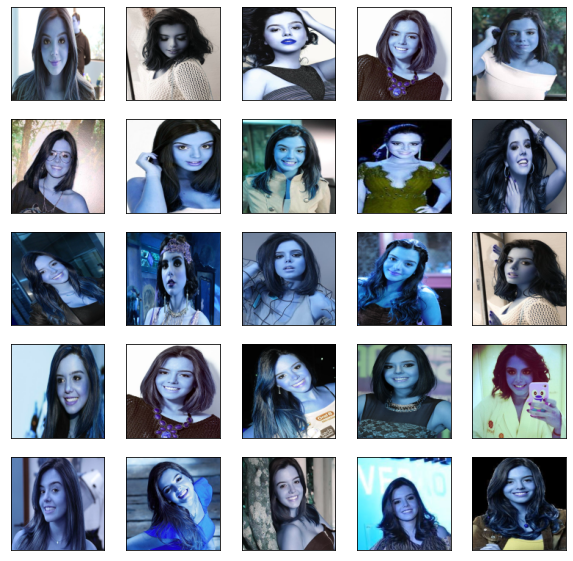

In [38]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
#     plt.imshow(original_cropped_storage[i])
    plt.imshow(X[i])
#     plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## SKlearn used for Splitting Training and Testing dataset

In [13]:
X.shape

(10000, 128, 128, 3)

In [14]:
y.shape

(10000,)

In [39]:
# Create dataset

class celebaDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            X,
            y,
            transform=None,
            crop_face=None,
            map_transform=None,
            ):
        self.X = X
        self.y = y
        self.transform = transform
        self.crop_face = crop_face
        self.map_transform = map_transform

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(X[idx,:]).permute(2, 0, 1), torch.tensor(y[idx])
    
    def show_img(self, idx):
        plt.imshow(X[idx,:])
        

In [60]:
tmp = celebaDataset(X, y)
a, b = tmp[609]

In [61]:
b

tensor(1)

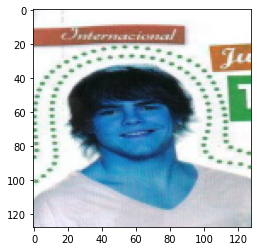

In [63]:
tmp.show_img(609)

## ===========================================================================================

In [16]:
!pip install facenet_pytorch

     |████████████████████████████████| 1.9 MB 20.9 MB/s eta 0:00:01


In [42]:
import torch
from torch import nn
from torchvision.models import resnet50
from facenet_pytorch import MTCNN, InceptionResnetV1

device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.mtcnn = MTCNN().eval().to(device)  # MTCNN на CPU
        self.resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dense = nn.Linear(128*8*8, 512, bias=False)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(512+512, 2)

    def forward(self, x):
        x = x.to(device)

#         print(x.shape)
        
        # First input
        x1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x1 = self.pool2(F.relu(self.bn2(self.conv2(x1))))
        x1 = x1.view(x.size(0), -1)
        x1 = self.dropout(self.bn3(self.dense(x1)))
        
#         print(x1.shape)

        # Second input
        x2_list = torch.zeros((x.size(0), 512)).to(device)
        for i in range(x.size(0)):
            img = x[i].permute(1, 2, 0).to(device)  # Перемещение изображения на CPU
            detected_faces = self.mtcnn(img)
            if detected_faces is not None:
                detected_faces = detected_faces.unsqueeze(0).to(device) # add batch dimension
                self.resnet.eval()
                detected_faces = self.resnet(detected_faces)
            else:
                detected_faces = torch.zeros((1, 512)).to(device) # assuming the output of resnet is of shape (batch_size, 512)
            x2_list[i] = detected_faces

#         print(x2_list.shape)
        # Merge
        x = torch.cat((x1, x2_list), dim=1)

        # Classification
        x = self.fc(x)

        return x


cpu


model2

In [43]:
import torch
from torch import nn
from torchvision.models import resnet50
from facenet_pytorch import MTCNN, InceptionResnetV1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dense = nn.Linear(128*8*8, 512, bias=False)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(512+512, 2)

    def forward(self, x, mtcnn, resnet):
        x = x.to(device)

#         print(x.shape)
        
        # First input
        x1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x1 = self.pool2(F.relu(self.bn2(self.conv2(x1))))
        x1 = x1.view(x.size(0), -1)
        x1 = self.dropout(self.bn3(self.dense(x1)))
        
#         print(x1.shape)

        # Second input
        x2_list = torch.zeros((x.size(0), 512)).to(device)
        for i in range(x.size(0)):
            img = x[i].permute(1, 2, 0).cpu()  # Перемещение изображения на CPU
            detected_faces = mtcnn(img)
            if detected_faces is not None:
                detected_faces = detected_faces.unsqueeze(0).to(device) # add batch dimension
                resnet.eval()
                detected_faces = resnet(detected_faces)
            else:
                detected_faces = torch.zeros((1, 512)).to(device) # assuming the output of resnet is of shape (batch_size, 512)
            x2_list[i] = detected_faces

#         print(x2_list.shape)
        # Merge
        x = torch.cat((x1, x2_list), dim=1)

        # Classification
        x = self.fc(x)

        return x



# # Обучение модели
# model = model.to(device)



cuda


In [44]:
model = CustomModel()
model.to(device)
o=0

In [45]:
train_idx, val_idx = train_test_split(range(len(tmp)), test_size=0.1, random_state=42)

train_dataset = Subset(tmp, train_idx)
val_dataset = Subset(tmp, val_idx)

In [46]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=1
)

valid_data_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=1
)


mtcnn_model = MTCNN().eval().cpu()  # MTCNN на CPU
resnet_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.metrics import f1_score

# Определение устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Функция обучения
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    for images, labels in tqdm(dataloader):
        images = images.to(device).float()
        labels = labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(images, mtcnn_model, resnet_model)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Обучение модели
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Функция валидации
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device).float()
            labels = labels.to(device).long()
            outputs = model(images, mtcnn_model, resnet_model)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Сохраняем метки и прогнозы для вычисления F1-оценки
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_loss /= len(dataloader.dataset)
    val_accuracy = 100. * correct / len(dataloader.dataset)

    # Вычисляем F1-оценку
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return val_loss, val_accuracy, f1

# Обучение и валидация модели
for epoch in range(1):  # 10 эпох для примера
    train(model, train_data_loader, criterion, optimizer, device)
    val_loss, val_accuracy, f1 = validate(model, valid_data_loader, criterion, device)
    torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')
    print(f'Epoch: {epoch}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, F1 Score: {f1}')


  0%|          | 0/141 [00:00<?, ?it/s]

cuda


 29%|██▉       | 41/141 [05:17<12:37,  7.58s/it]

In [48]:
torch.save(model.state_dict(), f'model_epoch_10.pth')



In [49]:
# # Загрузка весов модели
# model.load_state_dict(torch.load('model_epoch_0.pth'))  # Замените на имя вашего файла

# Перевод модели в режим оценки
model.eval()




CustomModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense): Linear(in_features=8192, out_features=512, bias=False)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

In [ ]:
# Загрузка новых данных для предсказания
new_data = plt.imread('/content/faces.jpg')

# Предсказание с помощью модели
with torch.no_grad():
    inputs = new_data.to(device).float()
    outputs = model(inputs)

# Получение предсказанных меток
_, predicted_labels = torch.max(outputs.data, 1)